<a href="https://colab.research.google.com/github/SkinCancer22/Project/blob/main/MvsB_V1_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba desempeño

# Parámetros de la prueba: 

Arquitectura: Inception V3


Datos:skin-cancer-malignant-vs-benign

Data Augmentation: No

K-Fold Validation: No

Hyperparameter Tuning: No

**Parámetros estáticos de entrenamiento:**


lr = 1e-3

init = 'normal'

activ = 'relu'

activ_last = 'softmax'

optim = 'adam'

epochs = 20


batch_size = 64



In [ ]:
# Librerias Basicas 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
import PIL.Image
from IPython.display import Image
# Librerias de preprocesamiento y metricas
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
# Librerias para backend, arquitectura y entrenamiento
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.core import Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"dianamerchanuis","key":"2218e75dd31a7dba96e741fd50c2a026"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 94% 306M/325M [00:02<00:00, 93.4MB/s]
100% 325M/325M [00:02<00:00, 133MB/s] 


In [ ]:
! unzip skin-cancer-malignant-vs-benign.zip ;

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/4

In [ ]:
# identificar las rutas y los nombres de las carpetas
folder_benign_train = '../content/data/train/benign'
folder_malignant_train = '../content/data/train/malignant'

folder_benign_test = '../content/data/test/benign'
folder_malignant_test = '../content/data/test/malignant'

read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

# cargar las imagenes de train 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Cargar las imagenes de test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Crear etiquetas
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Crear datos combinados para train y test 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Randomizar los datos
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

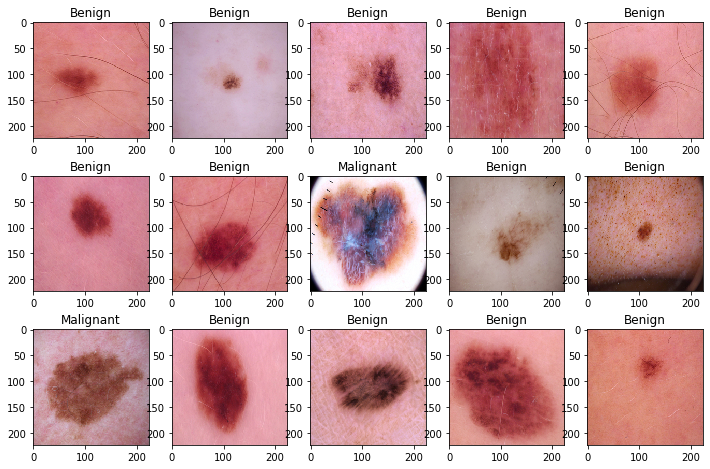

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [ ]:
# Etiquetas a categoricas 
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalización 
X_train = X_train/255.
X_test = X_test/255.

CREAR MODELO INCEPTION_V3 

In [ ]:
base_model=InceptionV3(input_shape = (224,224,3), weights='imagenet',include_top=False) # importar mobilenet y descartar la ultima capa

#image_input = Input(shape=(width_shape, height_shape, 3))
#model2 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

x=base_model.output
#x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) 
#x=Dense(1024,activation='relu')(x) 
#x=Dense(512,activation='relu')(x) 
preds=Dense(2,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
Model.summary(model)

87916544/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
input_shape = (224,224,3)
lr = 0.001
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 20
batch_size = 64

model.compile(optimizer = optim ,loss = "binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_split=0.2, epochs= epochs, batch_size= batch_size, verbose=1)         

Epoch 1/20
33/33 [==============================] - 34s 600ms/step - loss: 0.5362 - accuracy: 0.7440 - val_loss: 184.2603 - val_accuracy: 0.5473
Epoch 2/20
33/33 [==============================] - 15s 467ms/step - loss: 0.2739 - accuracy: 0.8727 - val_loss: 0.5952 - val_accuracy: 0.8314
Epoch 3/20
33/33 [==============================] - 16s 474ms/step - loss: 0.2182 - accuracy: 0.9071 - val_loss: 1.1936 - val_accuracy: 0.7784
Epoch 4/20
33/33 [==============================] - 16s 482ms/step - loss: 0.1530 - accuracy: 0.9399 - val_loss: 1.6499 - val_accuracy: 0.6667
Epoch 5/20
33/33 [==============================] - 16s 489ms/step - loss: 0.1795 - accuracy: 0.9305 - val_loss: 1.6546 - val_accuracy: 0.8068
Epoch 6/20
33/33 [==============================] - 16s 501ms/step - loss: 0.1751 - accuracy: 0.9405 - val_loss: 3.1378 - val_accuracy: 0.6155
Epoch 7/20
33/33 [==============================] - 17s 509ms/step - loss: 0.0646 - accuracy: 0.9785 - val_loss: 0.7573 - val_accuracy: 0.78

**max accruracy = 0.8390**


**VAL_LOSS minimo= 0.5739**

**val_loss final= 0.6038**



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


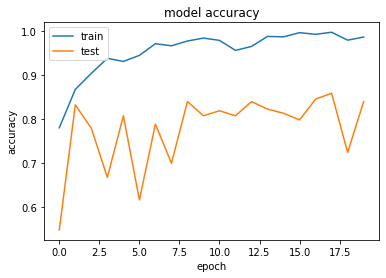

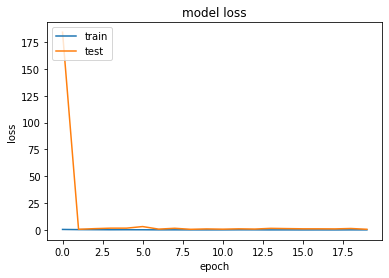

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()